# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep =';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [12]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [116]:
#Examine the rows and columns in the dataset
azdias.shape

(891221, 85)

In [117]:
#Examine the values in the dataset
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [118]:
#Examine the count of values in different columns
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [119]:
# Examine the feat_info dataset
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [120]:
#Examine the count of values in each column of feat_info dataset
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [259]:
#Create copies of the orginal dataset
feat_info_copy = feat_info.copy()
azdias_copy = azdias.copy()

In [122]:
#reset index in th original dataset
azdias.reset_index()

,index,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,0,-1,2,1,2.0,3,4,3,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,-1,1,2,5.0,1,5,2,5,4,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,2,-1,3,2,3.0,1,4,1,2,3,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,3,2,4,2,2.0,4,2,5,2,1,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,4,-1,3,1,5.0,4,3,4,1,3,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,5,3,1,2,2.0,3,1,5,2,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,6,-1,2,2,5.0,1,5,1,5,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,7,-1,1,1,3.0,3,3,4,1,3,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,8,-1,3,1,3.0,4,4,2,4,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,9,-1,3,2,4.0,2,4,2,3,5,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [ ]:
# Identify missing or unknown data values and convert them to NaN
feat_info.set_index('attribute', inplace=True)
for col_name in azdias.columns:
    azdias[col_name] = azdias[col_name].map(lambda x: np.nan if str(x) in feat_info.loc[col_name].missing_or_unknown else x)
    

In [11]:
#Since the above process takes a long time..we look to save the file to a csv
azdias.to_csv('azdias_parsed.csv', sep=';', index = False)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [3]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#Loading the dataset from the parsed csv file
azdias_parsed = pd.read_csv('azdias_parsed.csv', sep =';')

azdias_parsed = pd.DataFrame(azdias_parsed)

In [4]:
#Examing the new dataset
azdias_parsed.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
#Testing the formula to identify NaN values
azdias_parsed.shape[0] - azdias_parsed['AGER_TYP'].count()

0

In [6]:
# Investigate patterns in the amount of missing data in each column.
zx=[]
for columns in azdias_parsed.columns:
    zx.append(azdias_parsed.shape[0]- azdias_parsed[columns].count()) 

In [7]:
#creating a dataframe
zx = pd.DataFrame(zx)

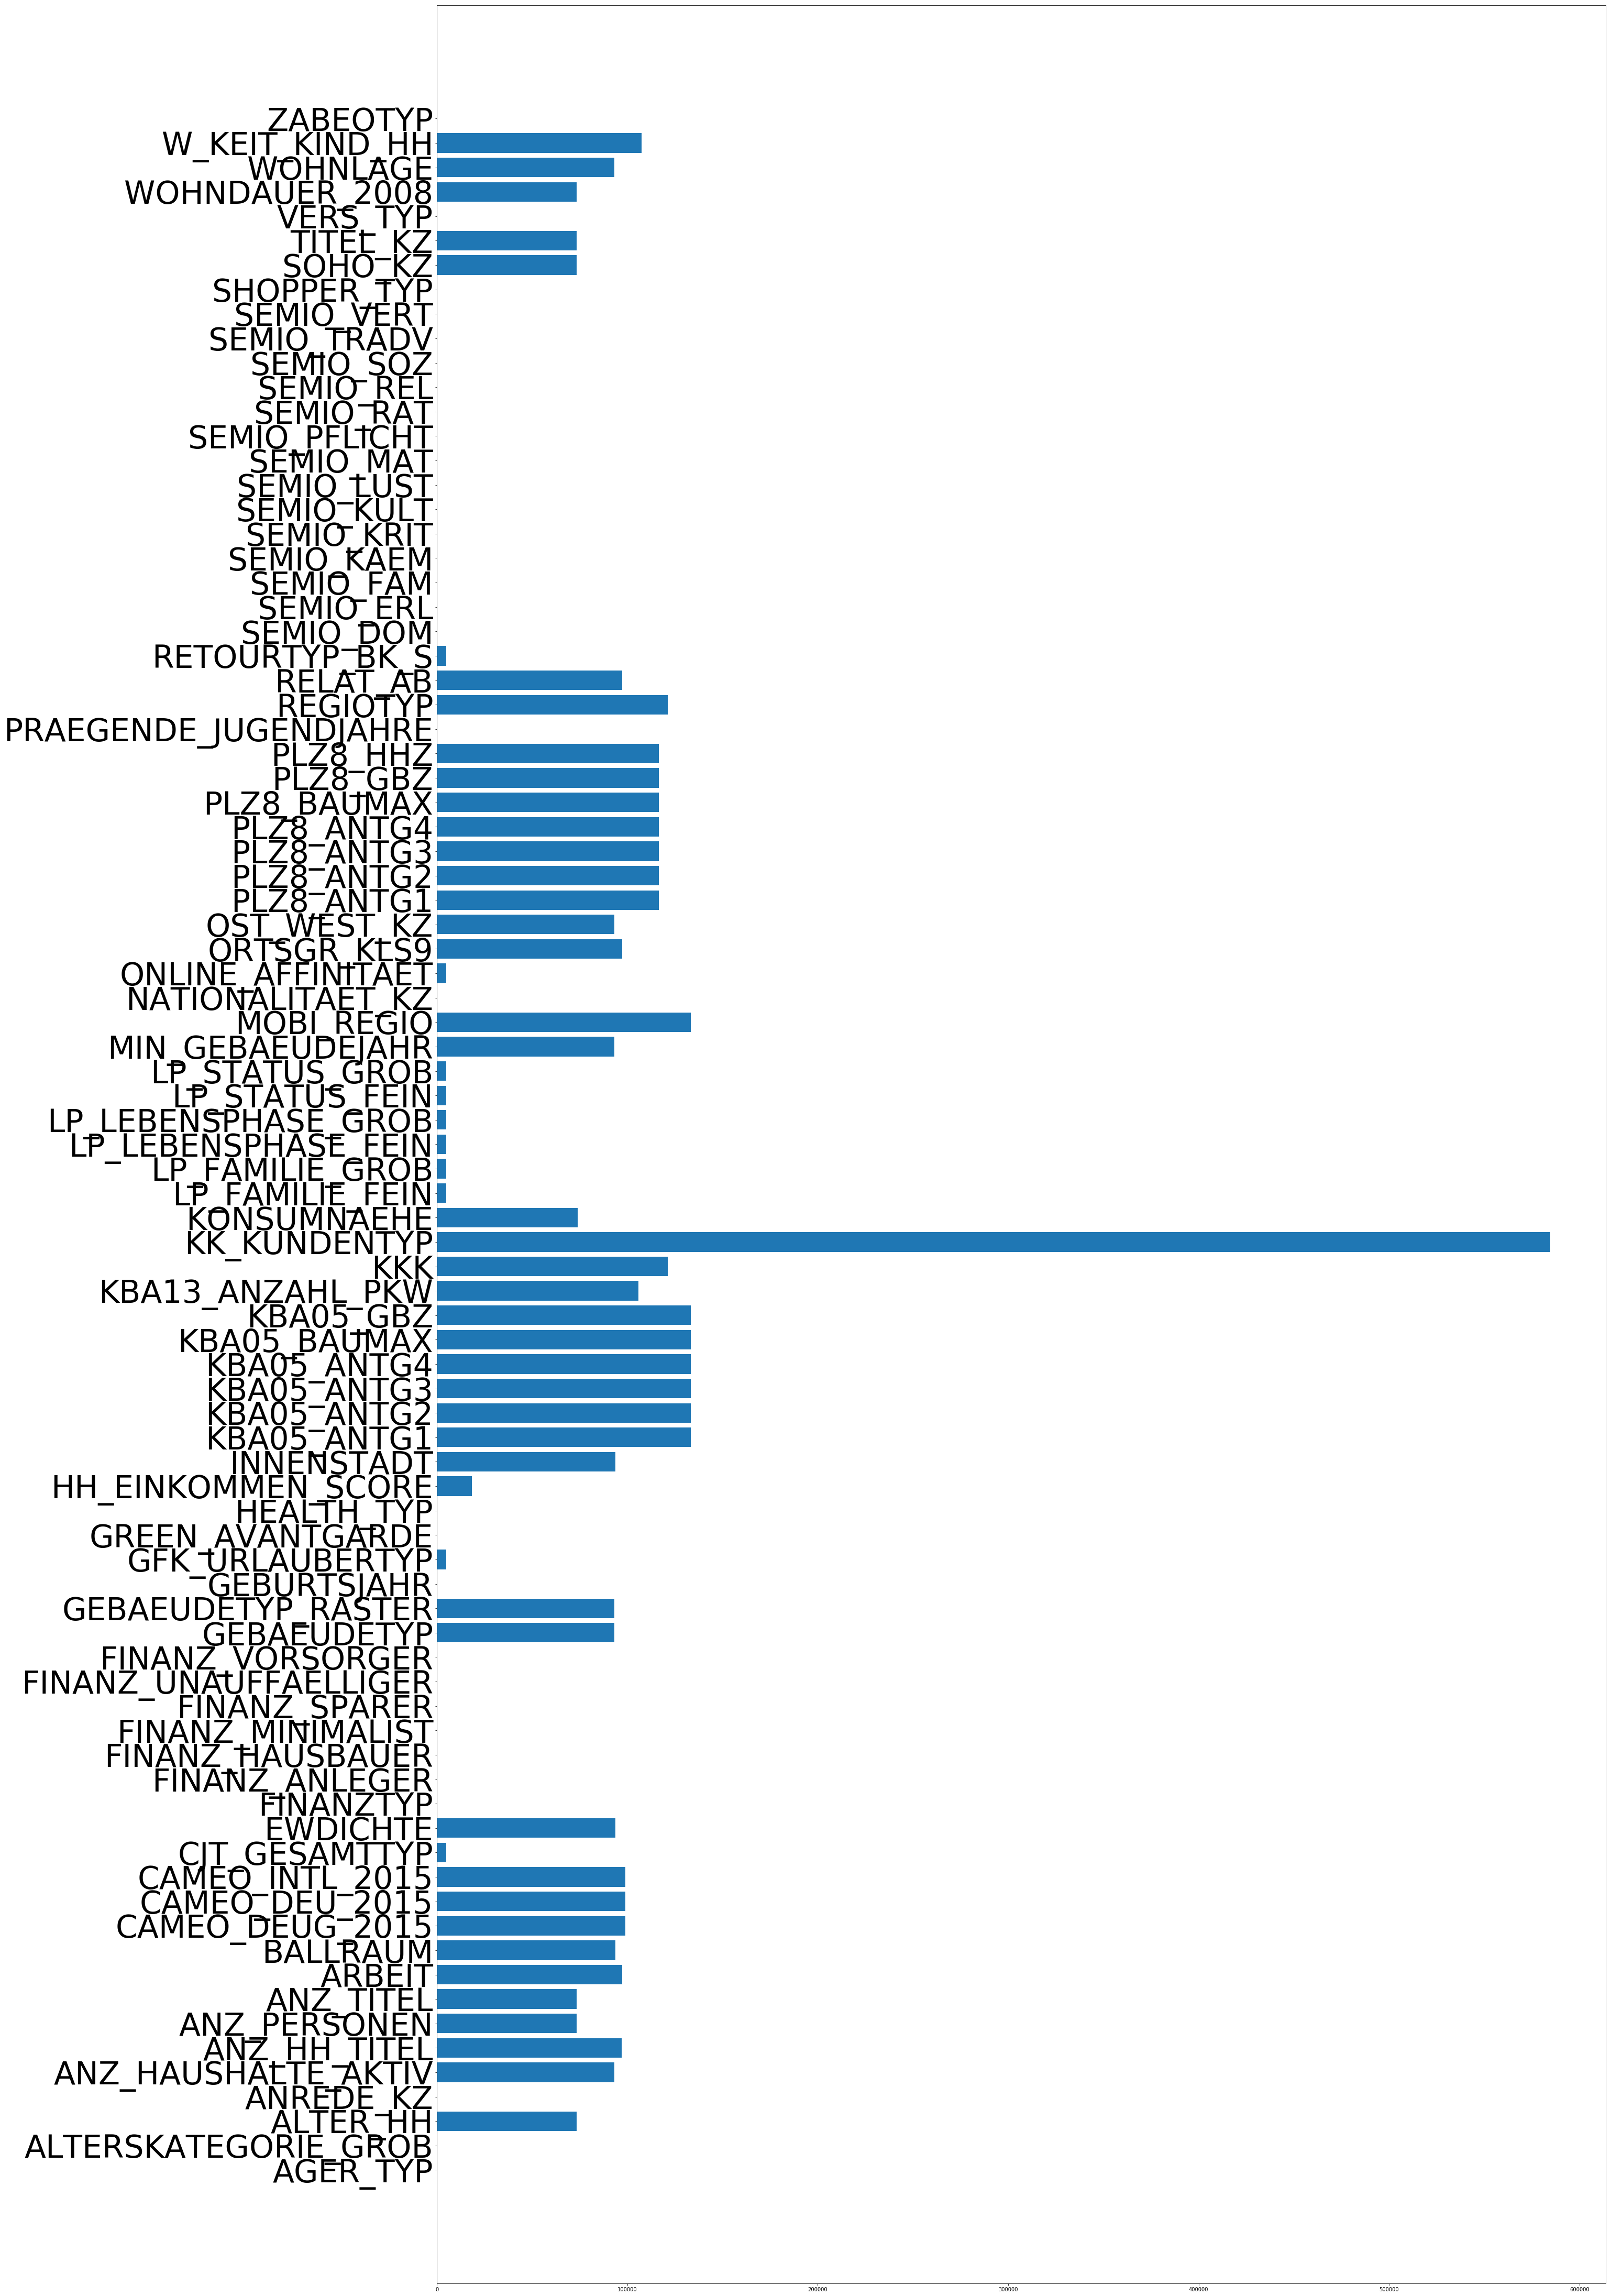

In [9]:
#Identifying the columns with highest NaN values
plt.figure(figsize=(40,80))
plt.barh(azdias_parsed.columns, zx[0], align='center')
plt.rc('ytick', labelsize=120)

In [10]:
#Narrowing down columns with more than 12% of NaN values
high_NaN =[]
for column in azdias_parsed.columns:
    if ((azdias_parsed.shape[0]- azdias_parsed[column].count())/ azdias_parsed.shape[0]) > 0.12:
        high_NaN.append(column)

high_NaN
    

['KK_KUNDENTYP',
 'W_KEIT_KIND_HH',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_BAUMAX',
 'KBA05_GBZ',
 'KKK',
 'MOBI_REGIO',
 'REGIOTYP',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_HHZ',
 'PLZ8_GBZ']

In [11]:
# Dropping columns that have 12% of their values to be NaN 
azdias_parsed.drop(high_NaN, axis=1,inplace = True)

In [12]:
#Examining the shape of the new dataset
azdias_parsed.shape

(891221, 67)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Columns with NaN values to be greater than 12% of the total count were removed from the dataframe I felt this was a suitable as removing too many columns may cause a hinderance to our analysis. Some of the columns removed our dataframe are  based on "number of family houses in the microcell", "purchasing power in region", "Number of family houses in the PLZ8 region", "Number of households within the PLZ8 region" and "Number of buildings within the PLZ8 region".

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [13]:
# How much data is missing in each row of the dataset?
dx=azdias_parsed
column_sum = azdias_parsed.columns
dx['NaN_count'] = (azdias_parsed.shape[1]-(azdias_parsed[column_sum].count(axis=1))) 


In [14]:
#Examing the missing data count in NaN_count column
dx.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,NaN_count
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,797481.000000,797481.000000,797481.000000,798066.000000,886367.000000,785421.000000,794005.000000,794005.000000,794005.00000,891221.000000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,4.153043,3.939172,4.549491,3.738306,2.698691,619.701439,3.167854,5.293002,3.07222,2.483513
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,2.183710,1.718996,2.028919,0.923193,1.521524,340.034318,1.002376,2.303739,1.36298,7.012592
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.00000,0.000000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,3.000000,3.000000,1.000000,384.000000,3.000000,4.000000,2.00000,0.000000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,5.000000,4.000000,5.000000,4.000000,3.000000,549.000000,3.000000,5.000000,3.00000,0.000000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,6.000000,6.000000,6.000000,4.000000,4.000000,778.000000,4.000000,7.000000,4.00000,0.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,7.000000,6.000000,8.000000,5.000000,5.000000,2300.000000,9.000000,9.000000,9.00000,29.000000


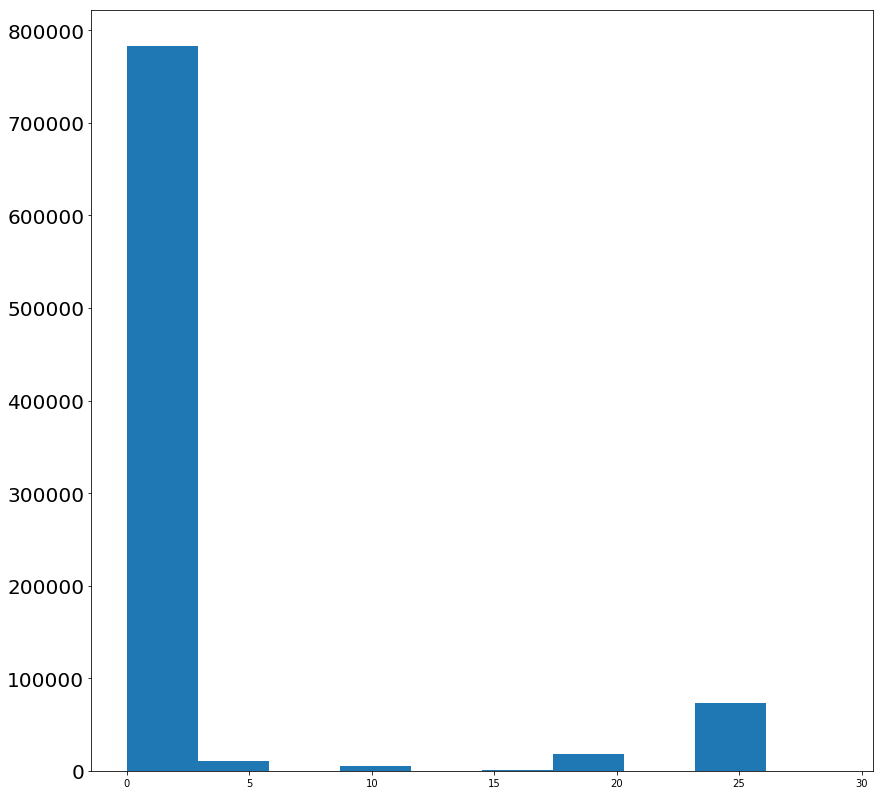

In [19]:
#Looking at how the NaN values are distributed
fig = plt.figure(figsize=(14, 14))
plt.hist(dx['NaN_count'])
plt.rcParams['ytick.labelsize']=10
plt.show()


In [16]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
subset1 = dx[dx['NaN_count'] < 12]
subset2 = dx[dx['NaN_count'] > 12]


In [17]:
# Creating a dataframe for the subsets
subset1 = pd.DataFrame(subset1)
subset2 = pd.DataFrame(subset2)

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


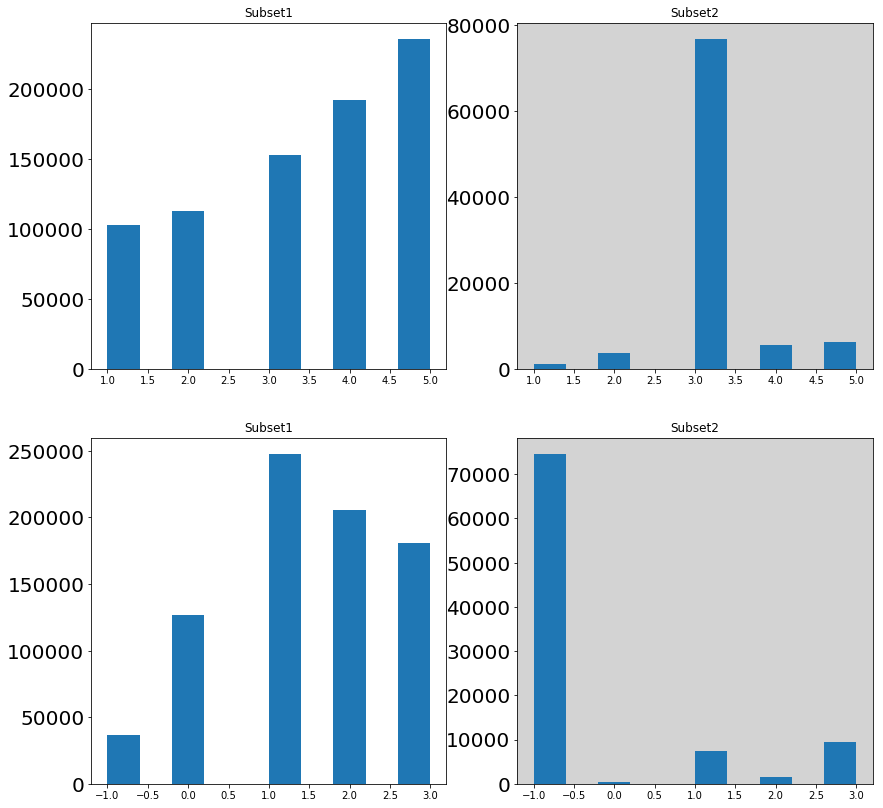

In [18]:
#Examing columns based on values in subset1 and subset2
python_course_green = "#476042"
fig = plt.figure(figsize=(14, 14))
sub1 = fig.add_subplot(221) 
sub1.set_title('Subset1') 
sub1.hist(subset1['FINANZ_VORSORGER'].dropna())
sub2 = fig.add_subplot(222, axisbg="lightgrey")
sub2.set_title('Subset2')
sub2.hist(subset2['FINANZ_VORSORGER'].dropna())
sub3 = fig.add_subplot(223)
sub3.set_title('Subset1')
sub3.hist(subset1['SHOPPER_TYP'].dropna())
sub4 = fig.add_subplot(224, axisbg="lightgrey")
sub4.set_title('Subset2')
sub4.hist(subset2['SHOPPER_TYP'].dropna())
plt.rcParams['ytick.labelsize']=20
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


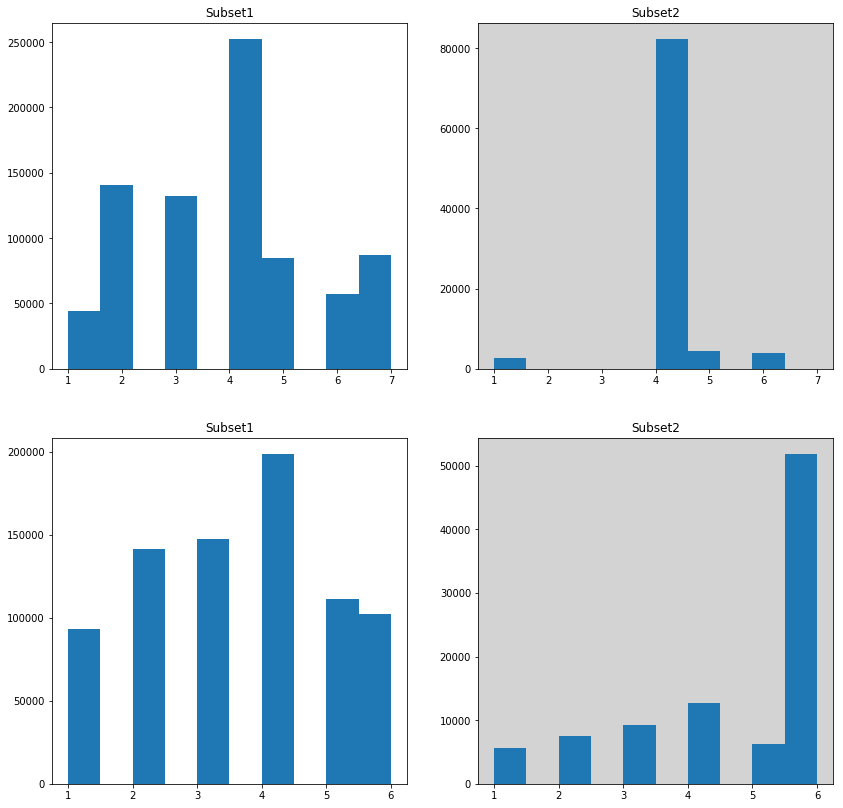

In [22]:
#Examing columns based on values in subset1 and subset2
python_course_green = "#476042"
fig = plt.figure(figsize=(14, 14))
sub1 = fig.add_subplot(221) 
sub1.set_title('Subset1') 
sub1.hist(subset1['SEMIO_RAT'].dropna())
sub2 = fig.add_subplot(222, axisbg="lightgrey")
sub2.set_title('Subset2')
sub2.hist(subset2['SEMIO_RAT'].dropna())
sub3 = fig.add_subplot(223)
sub3.set_title('Subset1')
sub3.hist(subset1['CJT_GESAMTTYP'].dropna())
sub4 = fig.add_subplot(224, axisbg="lightgrey")
sub4.set_title('Subset2')
sub4.hist(subset2['CJT_GESAMTTYP'].dropna())
plt.rcParams['ytick.labelsize']=20
plt.show()



/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


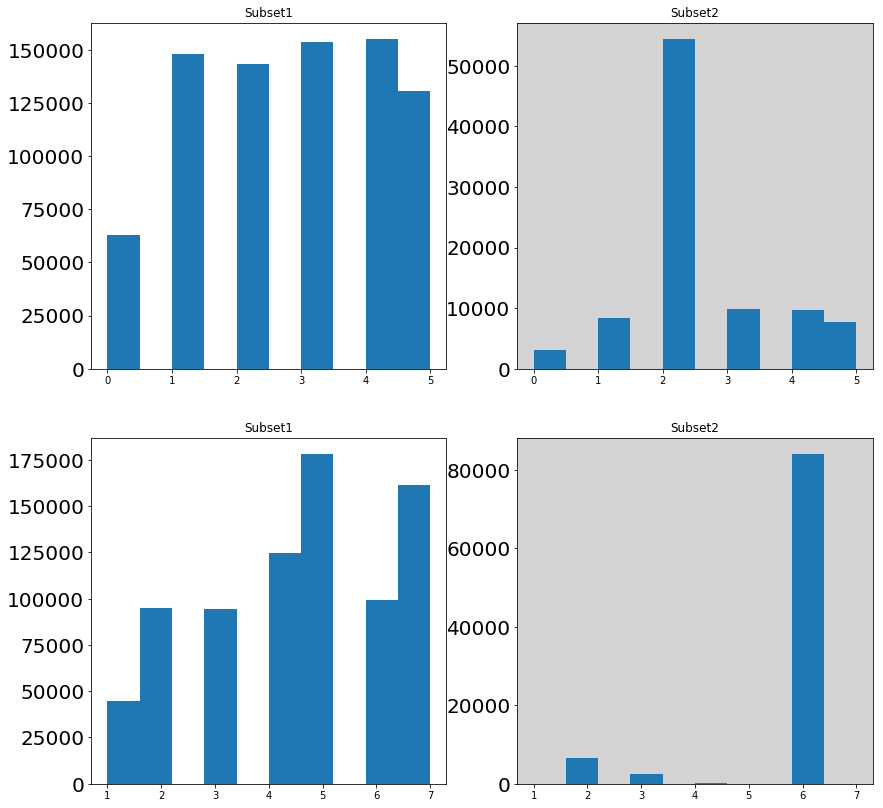

In [23]:
#Examing columns based on values in subset1 and subset2
python_course_green = "#476042"
fig = plt.figure(figsize=(14, 14))
sub1 = fig.add_subplot(221) 
sub1.set_title('Subset1') 
sub1.hist(subset1['ONLINE_AFFINITAET'].dropna())
sub2 = fig.add_subplot(222, axisbg="lightgrey")
sub2.set_title('Subset2')
sub2.hist(subset2['ONLINE_AFFINITAET'].dropna())
sub3 = fig.add_subplot(223)
sub3.set_title('Subset1')
sub3.hist(subset1['SEMIO_DOM'].dropna())
sub4 = fig.add_subplot(224, axisbg="lightgrey")
sub4.set_title('Subset2')
sub4.hist(subset2['SEMIO_DOM'].dropna())
plt.rcParams['ytick.labelsize']=20
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

The rows in subset1 are well distributed when compared to rows in subset2. On observing in the graph with "CJT_GESAMTTYP" (Customer-Journey Typology preferred information and buying channels for customer) and "ONLINE_AFFINITAET" (Online affinity), we find a wider range of values in the columns with few NaN values. In the others distributions, we find that higher number of values are in subset1 when compared to subset2 which works well for our analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [ ]:
# How many features are there of each data type?
cat = feat_info[feat_info['type'] == 'categorical']
mix = feat_info[feat_info['type'] == 'mixed']


In [ ]:
# reseting the index in the dataframe
cat = cat.reset_index()
mix = mix.reset_index()

In [ ]:
# Examing the dataset
cat.head()

In [ ]:
#Reseting the subset1 dataset
subset1.reset_index()

In [ ]:
# Identfying and creating a dataet with category data type values
category=[]
category = pd.DataFrame(category)
for columns in subset1.columns:
    for col in cat['attribute']:
        if columns == col:
            category[col] = (subset1[col])

In [ ]:
# Creating a dataframe
category = pd.DataFrame(category)
category.head()

In [ ]:
# Looking at the values in category column
for column in category.columns:
    print(category[column].value_counts())
    

In [ ]:
# looking at the values in the OST_WEST_KZ column
category['OST_WEST_KZ'].value_counts()

In [ ]:
# Looking at the values in the CAMEO_DEU_2015 column
category['CAMEO_DEU_2015'].value_counts()

In [ ]:
## Identfying and creating a dataet with mixed data type values
mixed=[]
mixed = pd.DataFrame(mixed)
for columns in subset1.columns:
    for col in mix['attribute']:
        if columns == col:
            mixed[col] = (subset1[col])

In [ ]:
# Creating a dataframe
mixed = pd.DataFrame(mixed)
mixed.head()

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [331]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
subset1['OST_WEST_KZ'] =subset1['OST_WEST_KZ'].astype('category') 
subset1['OST_WEST_KZ'] = subset1['OST_WEST_KZ'].cat.codes


In [332]:
# Dropping the multi-level categorical column in the subset1 dataset
subset1.drop('CAMEO_DEU_2015', axis=1, inplace=True)

In [333]:
# Dropping the multi-level categorical column in category dataset
category.drop('CAMEO_DEU_2015', axis=1, inplace=True)

In [334]:
# Adjusting the index in the category dataset
category.index = pd.RangeIndex(len(category.index))


In [335]:
# Examining the category dataset
category.head()

,AGER_TYP,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015
0,-1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1,3,1.0,0.0,2,5,8.0,W,8
1,-1,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1,2,0.0,0.0,1,5,1.0,W,4
2,2,2,2.0,6,1.0,0,0.0,0.0,9.0,4.0,1,1,0.0,0.0,1,3,1.0,W,2
3,-1,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1,2,0.0,0.0,2,4,1.0,W,6
4,3,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1,0,0.0,0.0,2,4,1.0,W,8


In [336]:
# Reset the index in category dataset
category.reset_index(drop=True)

,AGER_TYP,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015
0,-1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1,3,1.0,0.0,2,5,8.0,W,8
1,-1,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1,2,0.0,0.0,1,5,1.0,W,4
2,2,2,2.0,6,1.0,0,0.0,0.0,9.0,4.0,1,1,0.0,0.0,1,3,1.0,W,2
3,-1,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1,2,0.0,0.0,2,4,1.0,W,6
4,3,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1,0,0.0,0.0,2,4,1.0,W,8
5,-1,2,5.0,4,12.0,0,1.0,1.0,2.0,1.0,1,1,0.0,0.0,1,4,1.0,W,4
6,-1,1,3.0,5,9.0,0,1.0,1.0,1.0,1.0,1,0,0.0,0.0,1,1,8.0,W,2
7,-1,1,3.0,6,3.0,1,1.0,1.0,10.0,5.0,1,3,0.0,0.0,2,6,3.0,W,1
8,-1,2,4.0,1,12.0,1,1.0,1.0,3.0,2.0,1,3,0.0,0.0,2,4,3.0,W,1
9,0,2,1.0,6,8.0,0,1.0,1.0,1.0,1.0,1,2,0.0,0.0,2,3,1.0,W,9


In [338]:
# Examining the feat_info dataset
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [339]:
# Making the col_names to be the index
feat_info['col_names'] = feat_info.index

In [340]:
# Making the attribute column to be the index
feat_info.set_index('attribute', inplace=True)

In [341]:
# Identifying category columns with more than 2 unqiue values
non_binary_cat = []
for col in category.columns:
    if feat_info.loc[col].type == 'categorical' and len(subset1[col].unique()) > 2:
        non_binary_cat.append(col)
            

In [342]:
# Examining these values
non_binary_cat

['AGER_TYP',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

In [343]:
# Dropping these values from the subset1 dataset
subset1.drop(non_binary_cat, axis=1, inplace=True)

In [344]:
# Looking at the shape for subset1
subset1.shape

(798016, 52)

#### Discussion 1.2.1: Re-Encode Categorical Features

We find that column 'OST_WEST_KZ has two categorical values. We can use label encoding to encode the variables as numbers to the column. We find that the column 'CAMEO_DEU_2015' has multiple categorical values, we can choose to drop this column. As one hot encoding this column, will create too many columns for our analysis. We also drop all other categorical columns to help with our analysis.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [345]:
# Examining the mixed dataset
mixed.head()


,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015
1,21.0,6.0,14,4.0,51
2,3.0,1.0,15,2.0,24
3,0.0,0.0,8,7.0,12
4,32.0,10.0,8,3.0,43
5,8.0,2.0,3,7.0,54


In [346]:
# Examining the values in the PRAEGENDE_JUGENDJAHRE
subset1['PRAEGENDE_JUGENDJAHRE'].value_counts()

14    182976
8     141616
10     85803
5      84685
3      53838
15     42544
11     35751
9      33567
0      28760
6      25652
12     24446
1      20677
4      20451
2       7479
13      5762
7       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [347]:
# Creating the decade column from PRAEGENDE_JUGENDJAHRE dataset
def make_interval(x):
    if x in (1,2):
        return 1
    if x in (3,4):
        return 2
    if x in (5,6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11,12,13):
        return 5
    if x in (14,15):
        return 6
    
        
subset1['decade'] = subset1['PRAEGENDE_JUGENDJAHRE'].apply(make_interval)

In [348]:
# Creating the binary column from PRAEGENDE_JUGENDJAHRE dataset
def binary_var(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    if x in (1,3,5,8,10,12,14):
        return 1
  
subset1['PRAEGENDE_JUGENDJAHRE_binary'] = subset1['PRAEGENDE_JUGENDJAHRE'].apply(binary_var)

In [349]:
# Examining the values in the CAMEO_INTL_2015
subset1['CAMEO_INTL_2015'].value_counts()

51    133689
41     92336
24     91157
14     62883
43     56669
54     45389
25     39626
22     33154
23     26748
13     26333
45     26131
55     23955
52     20540
31     19023
34     18523
15     16974
44     14819
12     13248
35     10355
32     10354
33      9935
XX       373
Name: CAMEO_INTL_2015, dtype: int64

In [350]:
# Replacing the XX values in the CAMEO_INTL_2015
subset1['CAMEO_INTL_2015'] = subset1['CAMEO_INTL_2015'].str.replace('XX',subset1['CAMEO_INTL_2015'].mode()[0] )

In [351]:
# Replacing the na values in subset1 with the mode
for col in subset1.columns:
    subset1[col] = subset1[col].fillna(subset1[col].mode()[0])

In [352]:
# Converting the CAMEO_INTL_2015 to the int datatype     
subset1['CAMEO_INTL_2015'] = subset1['CAMEO_INTL_2015'].astype(int)

In [353]:
# Creating the weath and lifespan functions.
def weath(number):
    if (number) // 10 == 1:
        return 1
    if (number) // 10 ==2:
        return 2
    if (number) // 10 == 3:
        return 3
    if (number) // 10 ==4:
        return 4
    if (number) // 10 ==5:
        return 5
    if (number) // 10 ==6:
        return 6
    
def lifespan(number):
    if number % 10 ==1:
        return 1
    if number % 10==2:
        return 2
    if number %10 ==3:
        return 3
    if number %10 ==4:
        return 4
    if number %10 ==5:
        return 5
    if number %10 ==6:
        return 6
    
    

In [354]:
# Creating the weath and lifespan columns from CAMEO_INTL_2015 dataset
subset1['weath'] = subset1['CAMEO_INTL_2015'].apply(weath)
subset1['lifespan'] = subset1['CAMEO_INTL_2015'].apply(lifespan)

In [355]:
# Examining the weath column
subset1['weath'].head()

1    5
2    2
3    1
4    4
5    5
Name: weath, dtype: int64

In [356]:
# Dropping the CAMEO_INTL_2015 column from the subset1
subset1.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [357]:
# Dropping the PRAEGENDE_JUGENDJAHRE column from the subset1
subset1.drop('PRAEGENDE_JUGENDJAHRE',axis=1, inplace=True)

In [358]:
# Dropping the CAMEO_INTL_2015 and  PRAEGENDE_JUGENDJAHRE columns from the mixed dataset
mixed.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],axis=1, inplace=True)

In [359]:
# Dropping the columns in the mixed dataset
for col in mixed.columns:
    subset1.drop(col, axis=1, inplace=True)

In [360]:
# Examining the shape of the subset1 dataset
subset1.shape

(798016, 51)

#### Discussion 1.2.2: Engineer Mixed-Type Features

From 'PRAEGENDE_JUGENDJAHRE'(Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west), I engineered 'make_interval' column for decade and 'binary_var' column for movement. Weath and lifespan columns were engineered from the "CAMEO_INTL_2015' (Wealth / Life Stage Typology, mapped to international code) column. The Remaining mixed value columns based on "life stage, fine scale', 'life stafe, rough scale' and 'Neighborhood quality or rural flag' were dropped from the dataset. The 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' columns were dropped from the original dataset.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [65]:
# Creating a subset1_cleaned dataset
subset1.to_csv('subset1_cleaned_.csv')
subset1_= pd.read_csv('subset1_cleaned_.csv', sep=';')

In [3]:
# Creating the subset1 dataframe
subset1 = pd.read_csv('subset1_cleaned_.csv', sep=',')
subset1 = pd.DataFrame(subset1)

In [4]:
# Examining the subset1 dataset
subset1.head()

,Unnamed: 0,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,...,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,NaN_count,decade,PRAEGENDE_JUGENDJAHRE_binary,weath,lifespan
0,1,1,2,1,5,2,5,4,5,1996,...,3.0,963.0,3.0,5.0,4.0,0,6.0,1.0,5,1
1,2,3,2,1,4,1,2,3,5,1979,...,2.0,712.0,3.0,5.0,2.0,0,6.0,0.0,2,4
2,3,4,2,4,2,5,2,1,2,1957,...,1.0,596.0,2.0,3.0,3.0,0,4.0,1.0,1,2
3,4,3,1,4,3,4,1,3,2,1963,...,5.0,435.0,4.0,6.0,5.0,0,4.0,1.0,4,3
4,5,1,2,3,1,5,2,2,5,1943,...,1.0,1300.0,2.0,3.0,3.0,0,2.0,1.0,5,4


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [144]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info.set_index('attribute', inplace=True)
    for col_name in df.columns:
        df[col_name] = df[col_name].map(lambda x: np.nan if str(x) in feat_info.loc[col_name].missing_or_unknown else x)
    
    high_NaN =['KK_KUNDENTYP','W_KEIT_KIND_HH','KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','KBA05_BAUMAX','KBA05_GBZ','KKK',
 'MOBI_REGIO','REGIOTYP','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_BAUMAX','PLZ8_HHZ','PLZ8_GBZ']
    

    # remove selected columns and rows, ...
    df.drop(high_NaN, axis=1,inplace = True)
    
    dx=df
    column_sum = df.columns
    dx['NaN_count'] = (df.shape[1]-(df[column_sum].count(axis=1))) 
    
    subset1 = df[df['NaN_count'] < 12]
    subset2 = df[df['NaN_count'] > 12]
    
    subset1 = pd.DataFrame(subset1)
    subset2 = pd.DataFrame(subset2)
    
    cat = feat_info[feat_info['type'] == 'categorical']
    mix = feat_info[feat_info['type'] == 'mixed']
    cat = cat.reset_index()
    mix = mix.reset_index()
    
    subset1 = subset1.reset_index()
    
    category=[]
    category = pd.DataFrame(category)
    for columns in subset1.columns:
        for col in cat['attribute']:
            if columns == col:
                category[col] = (subset1[col])
    
    mixed=[]
    mixed = pd.DataFrame(mixed)
    for columns in subset1.columns:
        for col in mix['attribute']:
            if columns == col:
                mixed[col] = (subset1[col])
    
    # select, re-encode, and engineer column values.
    
    for x in subset1.columns:
        if x == 'OST_WEST_KZ':
            subset1[x] = subset1[x].astype('category') 
            subset1[x] = subset1[x].cat.codes
            
    subset1.drop('CAMEO_DEU_2015', axis=1, inplace=True)
    category.drop('CAMEO_DEU_2015', axis=1, inplace=True)
    
    #feat_info['col_names'] = feat_info.index
    #feat_info.set_index('attribute', inplace=True)
    
    non_binary_cat = []
    for col in category.columns:
        if feat_info.loc[col].type == 'categorical' and len(subset1[col].unique()) > 2:
            non_binary_cat.append(col)
            
    subset1.drop(non_binary_cat, axis=1, inplace=True)
    
    def make_interval(x):
        if x in (1,2):
            return 1
        if x in (3,4):
            return 2
        if x in (5,6,7):
            return 3
        if x in (8,9):
            return 4
        if x in (10,11,12,13):
            return 5
        if x in (14,15):
            return 6
    
    def binary_var(x):
        if x in (2,4,6,7,9,11,13,15):
            return 0
        if x in (1,3,5,8,10,12,14):
            return 1
    
    def weath(number):
        if (number) // 10 == 1:
            return 1
        if (number) // 10 ==2:
            return 2
        if (number) // 10 == 3:
            return 3
        if (number) // 10 ==4:
            return 4
        if (number) // 10 ==5:
            return 5
        if (number) // 10 ==6:
            return 6
    
    def lifespan(number):
        if number % 10 ==1:
            return 1
        if number % 10==2:
            return 2
        if number %10 ==3:
            return 3
        if number %10 ==4:
            return 4
        if number %10 ==5:
            return 5
        if number %10 ==6:
            return 6
    
    
    subset1['decade'] = subset1['PRAEGENDE_JUGENDJAHRE'].apply(make_interval)    
    subset1['PRAEGENDE_JUGENDJAHRE_binary'] = subset1['PRAEGENDE_JUGENDJAHRE'].apply(binary_var)
    
    for col in subset1.columns:
        subset1[col] = subset1[col].fillna(subset1[col].mode()[0])    
    subset1['CAMEO_INTL_2015'] = subset1['CAMEO_INTL_2015'].astype(int)

    subset1['weath'] = subset1['CAMEO_INTL_2015'].apply(weath)
    subset1['lifespan'] = subset1['CAMEO_INTL_2015'].apply(lifespan)
    mixed.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],axis=1, inplace=True)
    subset1.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],axis=1, inplace=True)
    
    for col in mixed.columns:
        subset1.drop(col, axis=1, inplace=True)
    
    for col in subset1.columns:
        if col == 'NaN_count':
            subset1.drop(col, inplace=True)
        if col == 'VERS_TYP':
            subset1.drop(col, inplace=True)
        if col == 'index':
            subset1.drop(col, inplace=True)
    
    
    # Return the cleaned dataframe.
    return subset1
    
    
    

    
  

    
   
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [5]:
# Checking for null values
subset1[subset1.isnull().any(1)]

,Unnamed: 0,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,...,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,NaN_count,decade,PRAEGENDE_JUGENDJAHRE_binary,weath,lifespan


In [6]:
# Dropping the NAN_count column
subset1.drop(['NaN_count','Unnamed: 0'] , axis=1, inplace=True)

In [7]:
# Converting all the columns to the numeric columns
for n in subset1.columns:
    subset1[n] = pd.to_numeric(subset1[n], errors='coerce')

In [8]:
# Checking again for null values
pd.isnull(subset1).sum() > 0

ALTERSKATEGORIE_GROB            False
ANREDE_KZ                       False
FINANZ_MINIMALIST               False
FINANZ_SPARER                   False
FINANZ_VORSORGER                False
FINANZ_ANLEGER                  False
FINANZ_UNAUFFAELLIGER           False
FINANZ_HAUSBAUER                False
GEBURTSJAHR                     False
GREEN_AVANTGARDE                False
HEALTH_TYP                      False
RETOURTYP_BK_S                  False
SEMIO_SOZ                       False
SEMIO_FAM                       False
SEMIO_REL                       False
SEMIO_MAT                       False
SEMIO_VERT                      False
SEMIO_LUST                      False
SEMIO_ERL                       False
SEMIO_KULT                      False
SEMIO_RAT                       False
SEMIO_KRIT                      False
SEMIO_DOM                       False
SEMIO_KAEM                      False
SEMIO_PFLICHT                   False
SEMIO_TRADV                     False
SOHO_KZ     

In [9]:
# Apply feature scaling to the general population demographics data.

normalizer  = StandardScaler()   
subset1[subset1.columns] = normalizer.fit_transform(subset1[subset1.columns].as_matrix()) 
    


In [10]:
# Checking the shape of the subset1
subset1.shape

(798016, 50)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Each feature is scaled using the standardscaler to a mean 0 and standard deviation of 1. We then use fit_transform() to fit a procedure and apply a transformation at the same time. Standardscaler assumes that data is normally distributed for within each feature.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [11]:
# Apply PCA to the data with 24 components
pca = PCA(n_components=24)


In [12]:
# Fit the pca to subset1
pca.fit(subset1)

PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [13]:
# Examine the pca explained variance ratio
pca.explained_variance_ratio_

array([ 0.17608098,  0.12929997,  0.10871637,  0.05992683,  0.03685884,
        0.03120466,  0.0285501 ,  0.02748984,  0.02634869,  0.0243929 ,
        0.0218596 ,  0.02088824,  0.02052528,  0.01998441,  0.01811398,
        0.01719714,  0.01646971,  0.01567058,  0.01393748,  0.01359186,
        0.01228267,  0.01067895,  0.01044907,  0.00981722])

In [14]:
# Investigate the variance accounted for by each principal component.
variance=[]
for x in range(len(pca.explained_variance_ratio_)):
    variance.append(pca.explained_variance_ratio_[x])
    


In [15]:
# Creating a dataframe
variance=pd.DataFrame(variance)

In [16]:
# Changing the variance column
variance.columns = ['values']

In [17]:
# Reset the variance dataframe
variance = variance.reset_index()

In [18]:
# Creating the index column of the dataframe
c=[]
for i in range(0,23):
    c.append(i)
c=pd.DataFrame(c)


In [20]:
# Creating the cumulative summation column from the values column
variance['cumsum'] = variance['values'].cumsum()

In [21]:
# Viewing the variance dataset
variance.head()

,index,values,cumsum
0,0,0.176081,0.176081
1,1,0.129300,0.305381
2,2,0.108716,0.414097
3,3,0.059927,0.474024
4,4,0.036859,0.510883


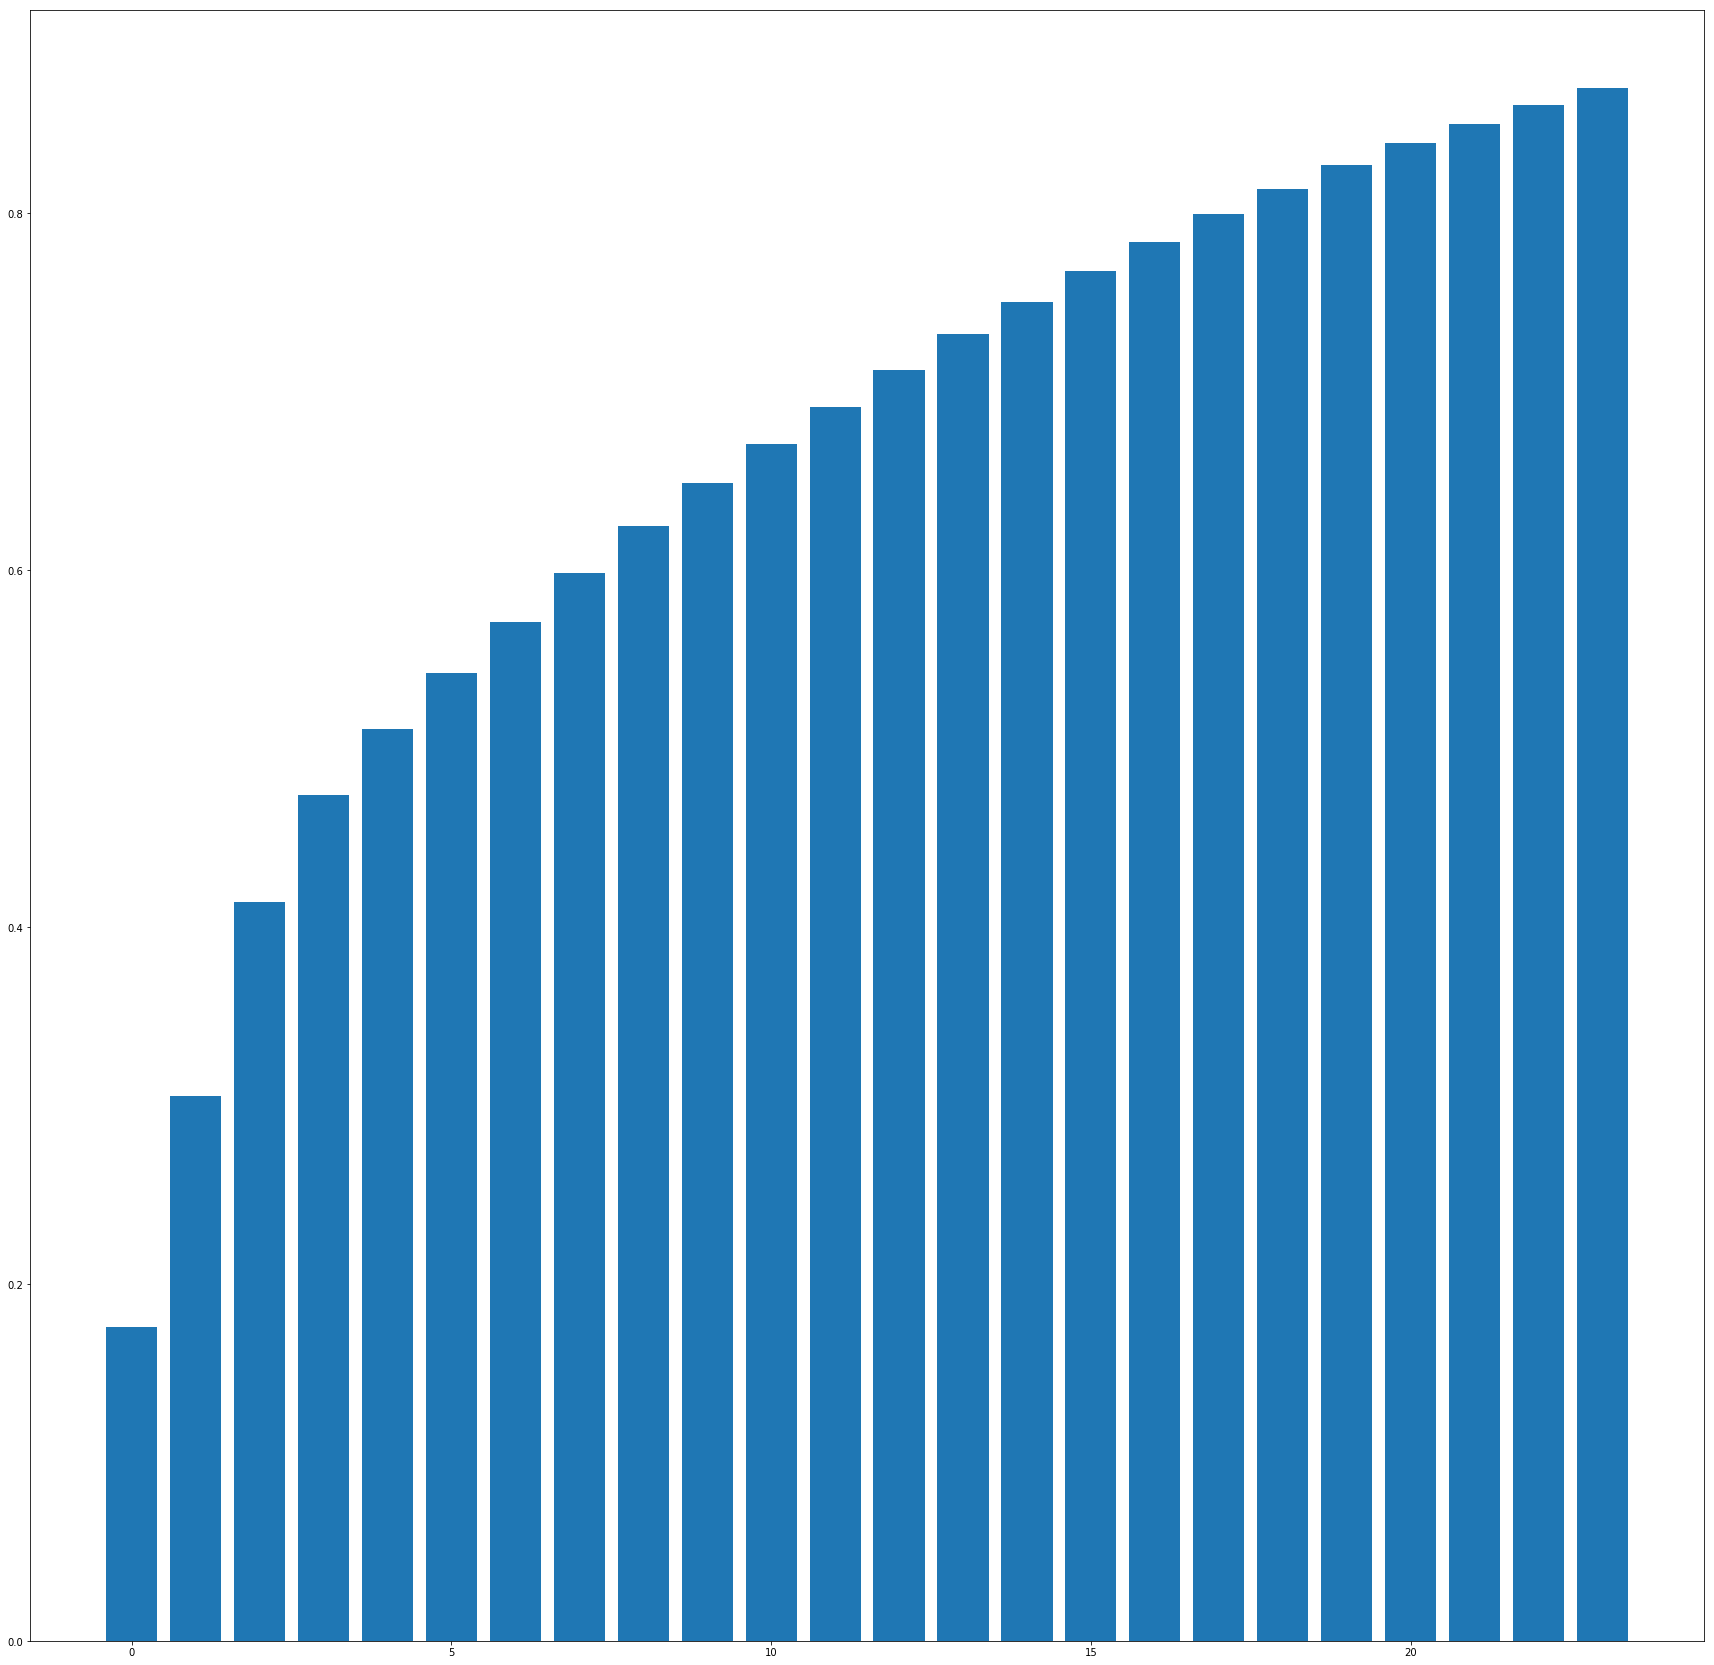

In [22]:
# Examining the bar chart of the variance dataset
plt.figure(figsize=(30,30))
plt.bar(variance['index'],variance['cumsum'])
#plt.rc('ytick', labelsize=30)
plt.rcParams.update({'font.size': 10})
#plt.yticks(0,0.2,1)

In [23]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components = 20)
pca.fit(subset1)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# Saving the dataset to a CSV file
subset1.to_csv('subset_pca.csv')

In [58]:
# Reading the csv file 
subset_pca = pd.read_csv('subset_pca.csv')

### Discussion 2.2: Perform Dimensionality Reduction

From the bar graph above, I find that 80% of the variance is explained by 20 principal components. I find that to be a suitable amount of the components to retain. We also see that beyond 20, the increase in variance is minimal.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [59]:
# Examining processed dataset values
from sklearn import preprocessing
data_scaled = pd.DataFrame(preprocessing.scale(subset1),columns = subset1.columns)
comp_data=[]
comp_data =  pd.DataFrame(pca.components_,columns=data_scaled.columns)
comp_data.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,PRAEGENDE_JUGENDJAHRE_binary,weath,lifespan
0,-0.272686,-0.065576,-0.186368,0.283900,-0.262718,0.212871,0.235330,-0.000464,0.031884,-0.050972,...,-0.033375,0.111735,-0.015734,0.030349,0.042087,0.026888,0.265079,0.050972,0.057833,-0.074645
1,-0.029037,0.303174,-0.244697,0.081372,-0.053964,0.092438,0.026966,0.206924,-0.035030,-0.120333,...,-0.090461,-0.078929,-0.063140,0.124892,0.163969,0.117954,0.047958,0.120333,0.162815,-0.086101
2,0.069774,-0.220973,-0.042650,-0.061564,0.085531,-0.176598,-0.115924,0.167212,-0.087370,-0.067767,...,-0.148163,-0.173896,-0.108437,0.202175,0.261203,0.188664,-0.107076,0.067767,0.225274,-0.113525
3,-0.042644,0.033314,0.096035,-0.013207,-0.014888,-0.124379,0.074719,-0.147780,0.112490,0.432228,...,-0.055460,0.196407,-0.017942,0.085331,0.283312,0.118553,0.033942,-0.432228,-0.136560,0.067812
4,-0.061283,0.040556,-0.010698,-0.011776,0.076003,-0.060168,0.093789,0.006302,-0.435815,0.138908,...,-0.074892,-0.281524,0.198549,-0.263640,-0.033409,-0.155309,-0.060108,-0.138908,-0.117388,0.054710


In [60]:
# Examining the shape of the dataset
comp_data.shape

(20, 50)

In [61]:
# Creating a dataframe of with the first component
p1=[]
p1 = pd.DataFrame(comp_data.head(1))

In [62]:
# Looking at the columns that have the highest variance values
p1.sort_values(by=0,axis=1,ascending=False)

,FINANZ_SPARER,SEMIO_REL,decade,SEMIO_PFLICHT,SEMIO_TRADV,FINANZ_UNAUFFAELLIGER,SEMIO_KULT,FINANZ_ANLEGER,SEMIO_RAT,SEMIO_FAM,...,SEMIO_KAEM,lifespan,WOHNDAUER_2008,SEMIO_KRIT,RETOURTYP_BK_S,FINANZ_MINIMALIST,SEMIO_LUST,SEMIO_ERL,FINANZ_VORSORGER,ALTERSKATEGORIE_GROB
0,0.2839,0.278068,0.265079,0.26014,0.247141,0.23533,0.222072,0.212871,0.200487,0.195926,...,-0.066229,-0.074645,-0.087331,-0.090508,-0.149449,-0.186368,-0.193045,-0.235488,-0.262718,-0.272686


In [63]:
# Looking at the dictionary dataset
import markdown
dict_ = open('Data_Dictionary.md', 'r')
dict_mark =markdown.markdown(dict_.read())
dict_mark


'<h1>Data Dictionary for Identify Customer Segments Data</h1>\n<h2>Introduction</h2>\n<p>The data for this project consist of two files:</p>\n<ul>\n<li>Udacity_AZDIAS_Subset.csv: demographics data for the general population of\n      Germany; 891211 persons (rows) x 85 features (columns)</li>\n<li>Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order\n      company; 191652 persons (rows) x 85 features (columns)</li>\n</ul>\n<p>The columns in the general demographics file and customers data file are the\nsame. This file documents the features that appear in the data files, sorted in\norder of appearance. Sections of this file is based on the level of measurement\nof each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of\nfeature attributes, including information level, data type, and codes for\nmissing or unknown values.</p>\n<h3>Table of Contents</h3>\n<ol>\n<li>Person-level features</li>\n<li>Household-level features</li>\n<li>Building-level 

In [64]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
p2=[]
p2 = pd.DataFrame(comp_data.head(2))
p2.sort_values(by=1,axis=1,ascending=False)

,SEMIO_KAEM,ANREDE_KZ,SEMIO_DOM,SEMIO_KRIT,FINANZ_HAUSBAUER,HH_EINKOMMEN_SCORE,SEMIO_ERL,ORTSGR_KLS9,weath,EWDICHTE,...,GEBAEUDETYP_RASTER,BALLRAUM,GREEN_AVANTGARDE,KONSUMNAEHE,INNENSTADT,SEMIO_FAM,SEMIO_SOZ,SEMIO_KULT,FINANZ_MINIMALIST,SEMIO_VERT
0,-0.066229,-0.065576,-0.041297,-0.090508,-0.000464,0.071563,-0.235488,0.042087,0.057833,0.039463,...,-0.033375,-0.026718,-0.050972,-0.040738,-0.036820,0.195926,0.107219,0.222072,-0.186368,0.029317
1,0.314300,0.303174,0.268261,0.245179,0.206924,0.189628,0.164755,0.163969,0.162815,0.162278,...,-0.090461,-0.108887,-0.120333,-0.132550,-0.136468,-0.194549,-0.196113,-0.203277,-0.244697,-0.304451


In [65]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
p3=[]
p3 = pd.DataFrame(comp_data.head(3))
p3.sort_values(by=2,axis=1,ascending=False)


,ORTSGR_KLS9,EWDICHTE,weath,ARBEIT,HH_EINKOMMEN_SCORE,RELAT_AB,SEMIO_VERT,SEMIO_SOZ,FINANZ_HAUSBAUER,SEMIO_FAM,...,GEBAEUDETYP_RASTER,SEMIO_RAT,SEMIO_KAEM,ONLINE_AFFINITAET,SEMIO_DOM,FINANZ_ANLEGER,BALLRAUM,KONSUMNAEHE,ANREDE_KZ,INNENSTADT
0,0.042087,0.039463,0.057833,0.030349,0.071563,0.026888,0.029317,0.107219,-0.000464,0.195926,...,-0.033375,0.200487,-0.066229,0.111735,-0.041297,0.212871,-0.026718,-0.040738,-0.065576,-0.036820
1,0.163969,0.162278,0.162815,0.124892,0.189628,0.117954,-0.304451,-0.196113,0.206924,-0.194549,...,-0.090461,0.151354,0.314300,-0.078929,0.268261,0.092438,-0.108887,-0.132550,0.303174,-0.136468
2,0.261203,0.256850,0.225274,0.202175,0.190930,0.188664,0.181273,0.180883,0.167212,0.166528,...,-0.148163,-0.152726,-0.158134,-0.173896,-0.174152,-0.176598,-0.181582,-0.206044,-0.220973,-0.224138


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

- On looking at the first row, we find that the column with the highest variance is FINANZ_SPARER (Financial typology for each dimension - describing if the person/group is a money saver). The column with the second highest variance is SEMIO_REL (personality typology for religion). The column with the third and fourth highest variance is decade(generation by decade) and SEMIO_PFLICHT(personality typology for dutiful). The FINANZ_VORSORGER  and FINANZ-MINIMALIST correpond to be prepared and low financial interest in financial typology. The FINANZ-MINIMALIST makes sense as a negative number as since the person/group is a money saver, they have low financial interest. FINANZ_VORSORGER looks to have a relationship with FINANZ_SPARER as if the person is a money saver, he is likely to be a be prepared.

- On the second row, we find the first to fourth ranking by variance to be SEMIO_KAEM(peronality typology for combative attitude), ANREDE_KZ (gender), SEMIO_DOM(peronality typology for dominant minded) and SEMIO_KRIT(peronality typology for critical-minded). SEMIO_SOZ(personality typology socially minded), SEMIO_KULT(peronality typology-culturally minded), FINANZ_MINIMALIST(Financial typology- low financial interest) and SEMIO_VERT(personality typology- dreamful) have fouth highest to highest negative variances. SEMIO_SOZ, SEMIO_KULT  and SEMIO_VERT are opposites of combative attitude, dominant minded and critical minded. FINANZ_HAUSBAUER (financial typology- home ownership)	has a high positive value. Home owners may not be frequent investors leading to negative value for FINANZ_MINIMALIST.

- On the third row, we find the first to fourth ranking by variance to be ORTSGR_KLS9(Size of the community), EWDICHTE(Density of households for square kilometer), weath (weath mapped to international code) and ARBEIT(share of unemployment in the community).BALLRAUM(Distance to nearest urban center), KONSUMNAEHE(Distance from building to point of sale), ANREDE_KZ (Gender), INNENSTADT (Distance to city center).We can see that EWDICHTE and  three columns - BALLRAUM,KONSUMNAEHE, INNENSTADT  are nearly the opposite of eachother, with greater emphasis on density of households, there is less emphasis on the distance to the nearest urban center, distance to point of sale and distance to city center. It is likely that gender is unknown which might be the reason for ANREDE_KZ to be negative. 



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
kscore=[]    
from sklearn.cluster import KMeans  
kmeans = KMeans(n_clusters=3).fit(subset1)
kscore.append(kmeans.score(subset1))

In [ ]:
# Running k-means with 4 clusters
kmeans1 = KMeans(n_clusters=4).fit(subset1)
kscore.append(kmeans1.score(subset1))

In [90]:
# Running k-means with 5 clusters
kmeans2 = KMeans(n_clusters=5).fit(subset1)
kscore.append(kmeans2.score(subset1))

In [91]:
# Running k-means with 6 clusters
kmeans3 = KMeans(n_clusters=6).fit(subset1)
kscore.append(kmeans3.score(subset1))

In [92]:
# Running k-means with 7 clusters
kmeans4 = KMeans(n_clusters=7).fit(subset1)
kscore.append(kmeans4.score(subset1))

In [93]:
# Running k-means with 8 clusters
kmeans8 = KMeans(n_clusters=8).fit(subset1)
kscore.append(kmeans8.score(subset1))

In [94]:
# Running k-means with 9 clusters
kmeans9 = KMeans(n_clusters=9).fit(subset1)
kscore.append(kmeans9.score(subset1))

NameError: name 'kmeans9score' is not defined

In [ ]:
# Running k-means with 10 clusters
kmeans10 = KMeans(n_clusters=10).fit(subset1)
kscore.append(kmeans10.score(subset1))

In [ ]:
# Examining the scores
kscore

In [12]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
from sklearn.cluster import KMeans  
def get_kmeans_score(data, center):
    
    kmeans = KMeans(n_clusters = center, n_init=10, max_iter=300, random_state=42)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score


In [ ]:
#creating a dataframe for analysis
score = []
centroids = [2,4,6,7,8,9,10,11,12,13,14,15,16,18,20,22,25]

for x in centroids:
    score.append(get_kmeans_score(subset1,x))

In [ ]:
#Making a dataframe
score = pd.DataFrame(score)

In [59]:
# checking the dataset for errors check how
score

,0
0,3.451463e+07
1,2.975918e+07
2,2.756201e+07
3,2.678209e+07


In [ ]:
#plotting the scatter plot
plt.plot(inv, inv.index, linestyle='--', marker='o', color='b');

In [30]:
# Transferring the dataset to a csv file
score.to_csv('kmeans_score.csv')

NameError: name 'score' is not defined

In [35]:
# Reading from a csv file
kmeans_score = pd.read_csv('kmeans_score.csv')

In [36]:
#Making a dataframe
kmeans_score = pd.DataFrame(kmeans_score)

In [37]:
# Examining the dataframe
kmeans_score

,Unnamed: 0,0
0,0,3.451463e+07
1,1,2.975918e+07
2,2,2.756201e+07
3,3,2.678209e+07
4,4,2.623291e+07
5,5,2.546226e+07
6,6,2.517953e+07
7,7,2.442150e+07
8,8,2.400038e+07
9,9,2.361268e+07


In [38]:
# List of clusters
x = [2,4,6,7,8,9,10,11,12,13,14,15,16,18,20,22,25]

In [40]:
#Creating a new column
kmeans_score['index'] = x

In [41]:
# Viewing the dataframe
kmeans_score

,Unnamed: 0,0,index
0,0,3.451463e+07,2
1,1,2.975918e+07,4
2,2,2.756201e+07,6
3,3,2.678209e+07,7
4,4,2.623291e+07,8
5,5,2.546226e+07,9
6,6,2.517953e+07,10
7,7,2.442150e+07,11
8,8,2.400038e+07,12
9,9,2.361268e+07,13


In [42]:
# Rename the columns
kmeans_score.columns = ['unknown','values','index']

In [43]:
# Examine the values
kmeans_score['values']

0     3.451463e+07
1     2.975918e+07
2     2.756201e+07
3     2.678209e+07
4     2.623291e+07
5     2.546226e+07
6     2.517953e+07
7     2.442150e+07
8     2.400038e+07
9     2.361268e+07
10    2.320980e+07
11    2.271379e+07
12    2.245438e+07
13    2.237902e+07
14    2.155805e+07
15    2.132601e+07
16    2.070142e+07
Name: values, dtype: float64

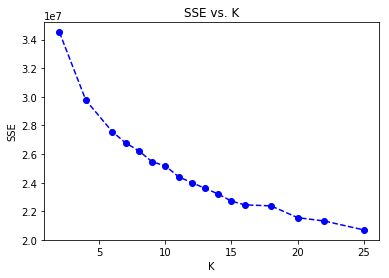

In [44]:
# View the change in within-cluster distance
plt.plot(kmeans_score['index'], kmeans_score['values'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
plt.figure(figsize=(50,80))

In [45]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans
new_score=[]
kmeans1 = KMeans(n_clusters=20).fit(subset1)
new_score.append(kmeans1.score(subset1))

In [46]:
# Predicting the general population demographics based on kmeans
general_predict = kmeans1.predict(subset1)

### Discussion 3.1: Apply Clustering to General Population

On plotting the kmeans scores with the number of clusters, we find that the slope of the curve starts to decrease when the number of clusters is 20. I believe that 20 is a good number to map the points in the dataset.



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [78]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers= pd.DataFrame(customers)

In [8]:
# Examine the customer dataset
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [9]:
# Examine thc columns and datatypes in the customers dataset
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [10]:
# Checking the OST_WEST_KZ column
customers['OST_WEST_KZ'].value_counts()

W    130382
O     11343
Name: OST_WEST_KZ, dtype: int64

In [142]:
# checking the VERS_TYP column
customers['VERS_TYP'].value_counts()

2.0    69042
Name: VERS_TYP, dtype: int64

In [42]:
# Cleaning the customers dataset using the clean_data function
customers_new  = clean_data(customers)

not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there
not there


In [44]:
# Save the cleaned dataset to csv
customers_new.to_csv('customers_cleaned.csv', sep=';', index = False)

In [47]:
# Read the cleaned dataset 
customers_cleaned = pd.read_csv('customers_cleaned.csv', sep=';') 

In [48]:
# Checking for null values
customers_cleaned[customers_cleaned.isnull().any(1)]

,index,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,...,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,NaN_count,decade,PRAEGENDE_JUGENDJAHRE_binary,weath,lifespan


In [49]:
# Creating a dataframe
customers_cleaned = pd.DataFrame(customers_cleaned)

In [50]:
# Examining the cleaned dataframe
customers_cleaned.head()

,index,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,...,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,NaN_count,decade,PRAEGENDE_JUGENDJAHRE_binary,weath,lifespan
0,2,4.0,2.0,5.0,2.0,5.0,2.0,4.0,4.0,1941.0,...,1.0,433.0,3.0,5.0,3.0,9,2.0,0.0,3,4
1,3,4.0,2.0,5.0,2.0,5.0,2.0,2.0,2.0,1941.0,...,2.0,755.0,1.0,3.0,1.0,10,2.0,0.0,2,4
2,4,3.0,2.0,3.0,2.0,4.0,4.0,5.0,2.0,1960.0,...,5.0,513.0,3.0,5.0,1.0,6,4.0,1.0,4,1
3,5,3.0,2.0,5.0,2.0,5.0,2.0,2.0,3.0,1941.0,...,3.0,1167.0,3.0,7.0,5.0,8,2.0,0.0,3,4
4,6,4.0,2.0,5.0,2.0,5.0,2.0,2.0,2.0,1942.0,...,4.0,1300.0,2.0,3.0,2.0,9,2.0,0.0,2,3


In [51]:
# Converting all the columns to numeric datatype
for n in customers_cleaned.columns:
    customers_cleaned[n] = pd.to_numeric(customers_cleaned[n], errors='coerce')

In [52]:
# Examining the datatypes and columns in the cleaned dataset
customers_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126858 entries, 0 to 126857
Data columns (total 53 columns):
index                           126858 non-null int64
ALTERSKATEGORIE_GROB            126858 non-null float64
ANREDE_KZ                       126858 non-null float64
FINANZ_MINIMALIST               126858 non-null float64
FINANZ_SPARER                   126858 non-null float64
FINANZ_VORSORGER                126858 non-null float64
FINANZ_ANLEGER                  126858 non-null float64
FINANZ_UNAUFFAELLIGER           126858 non-null float64
FINANZ_HAUSBAUER                126858 non-null float64
GEBURTSJAHR                     126858 non-null float64
GREEN_AVANTGARDE                126858 non-null int64
HEALTH_TYP                      126858 non-null float64
RETOURTYP_BK_S                  126858 non-null float64
SEMIO_SOZ                       126858 non-null float64
SEMIO_FAM                       126858 non-null float64
SEMIO_REL                       126858 non-null float

In [53]:
# Making sure that all the columns in the customers cleaned datset is in the subset1 dataset
needed=[]
for col in customers_cleaned:
    if col in subset1.columns:
        print('yes')
    else:
        needed.append(col)

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [54]:
# Examining the dataset to find out which columns dont match
needed

['index', 'VERS_TYP', 'NaN_count']

In [55]:
# Dropping the excess columns
customers_cleaned.drop(needed,  axis=1, inplace=True)

In [56]:
# normalizing and transfoming the dataset using the standard scaler 
customers_cleaned[customers_cleaned.columns] = normalizer.transform(customers_cleaned[customers_cleaned.columns].as_matrix())

In [57]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
pca.transform(customers_cleaned)
customer_predict = kmeans1.predict(customers_cleaned)




### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

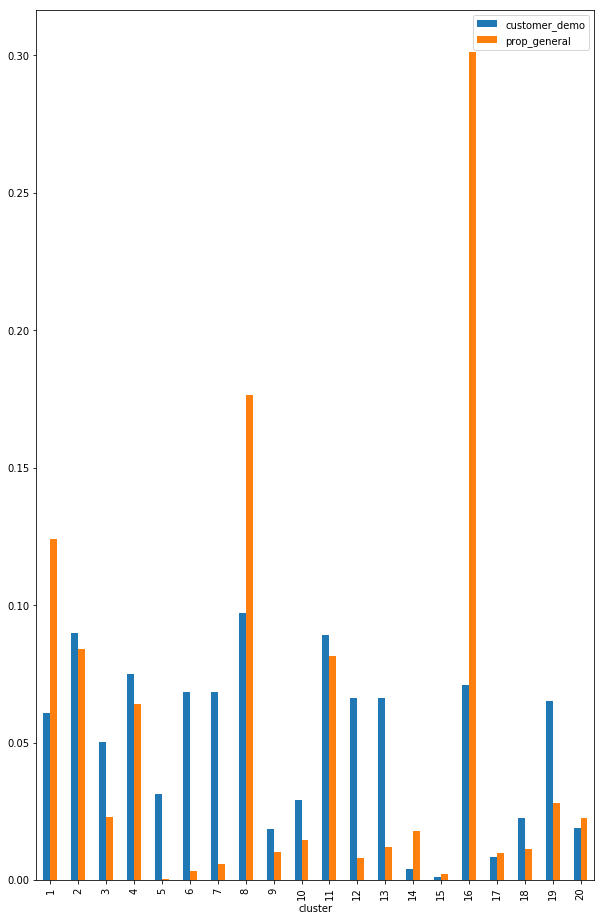

In [58]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
prop_cust=[]
prop_general=[]
for i in range(0,20):
    prop_cust.append((general_predict==i).sum()/len(general_predict))
    prop_general.append((customer_predict==i).sum()/len(customer_predict))

x = [i+1 for i in range(0,20)]
    
final = pd.DataFrame({'cluster': x, 'customer_demo': prop_cust, 'prop_general': prop_general})
final.plot(x='cluster', y=['customer_demo', 'prop_general'], kind='bar', figsize=(10,16))
plt.show()
    



In [86]:
# Examining a cluster to look at the values in the cluster
data_3 = normalizer.inverse_transform(pca.inverse_transform(hash(tuple(customers_cleaned)))).round()

customer_under_rep_features = pd.DataFrame(data_3).round(2)
customer_under_rep_features


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-8.449876e+16,-9.391393e+15,-7.360448e+16,1.208756e+17,-1.037057e+17,8.988321e+16,9.442374e+16,-1.872246e+14,8.769551e+18,-6.049162e+15,...,-8.833451e+15,4.978535e+16,-1.583841e+18,8.714561e+15,2.772802e+16,1.048016e+16,1.112815e+17,6.049162e+15,2.431912e+16,-3.184587e+16
1,-8.997991e+15,4.341903e+16,-9.664088e+16,3.464544e+16,-2.130169e+16,3.903114e+16,1.081974e+16,8.353395e+16,-9.634966e+18,-1.428082e+16,...,-2.394286e+16,-3.516800e+16,-6.355784e+18,3.586228e+16,1.080261e+17,4.597490e+16,2.013307e+16,1.428082e+16,6.846497e+16,-3.673321e+16
2,2.162143e+16,-3.164654e+16,-1.684433e+16,-2.621177e+16,3.376282e+16,-7.456719e+16,-4.651349e+16,6.750228e+16,-2.403078e+19,-8.042370e+15,...,-3.921478e+16,-7.748196e+16,-1.091552e+19,5.805355e+16,1.720864e+17,7.353561e+16,-4.495098e+16,8.042370e+15,9.472877e+16,-4.843334e+16
3,-1.321533e+16,4.771507e+15,3.792888e+16,-5.623492e+15,-5.876291e+15,-5.251779e+16,2.997913e+16,-5.965823e+16,3.093905e+19,5.129602e+16,...,-1.468117e+16,8.751339e+16,-1.805817e+18,2.450244e+16,1.866494e+17,4.620918e+16,1.424968e+16,-5.129602e+16,-5.741831e+16,2.893289e+16
4,-1.899256e+16,5.801600e+15,-4.228969e+15,-5.015659e+15,2.998888e+16,-2.544181e+16,3.767975e+16,2.569128e+15,-1.198441e+20,1.648524e+16,...,-1.982938e+16,-1.254069e+17,1.998755e+19,-7.569643e+16,-2.200785e+16,-6.054177e+16,-2.523710e+16,-1.648524e+16,-4.933634e+16,2.334739e+16
5,3.827197e+16,-5.183302e+15,-5.079071e+16,4.267577e+16,-8.971629e+15,6.579930e+15,6.101383e+16,1.083093e+16,5.397428e+19,-6.417673e+15,...,-7.375817e+16,6.368359e+16,2.551389e+19,-1.127308e+17,-2.416322e+16,-1.084310e+17,4.810398e+16,6.417673e+15,1.601578e+16,-5.662048e+16
6,4.621329e+16,3.687088e+15,-6.201356e+16,7.746284e+16,-6.749048e+16,1.005729e+17,5.848405e+16,7.239954e+16,-4.314840e+19,2.411121e+16,...,9.978869e+15,4.946012e+15,-1.317237e+19,4.585237e+16,-1.710994e+16,3.267628e+16,5.066700e+16,-2.411121e+16,-1.072245e+16,5.208583e+16
7,-4.380661e+16,7.507307e+15,2.084438e+16,-6.414315e+16,4.221630e+16,-2.462987e+16,-1.019425e+17,5.340722e+16,2.284493e+19,3.571905e+14,...,-2.500454e+16,1.423961e+16,-7.658424e+18,4.747424e+13,-4.115843e+16,-3.762523e+16,-6.067413e+16,-3.571905e+14,-1.873651e+16,6.948677e+16
8,6.017453e+14,-7.641071e+15,5.571011e+15,3.230675e+16,-7.427551e+16,3.622347e+16,2.971753e+16,-5.646572e+16,-4.271653e+19,1.018450e+16,...,-2.011513e+16,-2.940403e+16,-1.781341e+18,3.267363e+16,6.273357e+15,4.870549e+15,4.060919e+16,-1.018450e+16,-2.738464e+16,3.441030e+16
9,2.699263e+16,4.355631e+15,3.945788e+16,-3.793500e+16,1.338158e+15,-3.326577e+16,-1.268424e+16,-3.276295e+16,3.263492e+19,-1.630919e+16,...,-6.754676e+15,3.642386e+16,3.446577e+18,2.326326e+16,2.457719e+16,-1.643079e+16,-2.175564e+16,1.630919e+16,-2.138992e+16,1.819086e+16


In [88]:
customer_under_rep_features.columns = customers_cleaned.columns

In [90]:
customer_under_rep_features.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,PRAEGENDE_JUGENDJAHRE_binary,weath,lifespan
0,-8.449876e+16,-9.391393e+15,-7.360448e+16,1.208756e+17,-1.037057e+17,8.988321e+16,9.442374e+16,-1.872246e+14,8.769551e+18,-6.049162e+15,...,-8.833451e+15,4.978535e+16,-1.583841e+18,8.714561e+15,2.772802e+16,1.048016e+16,1.112815e+17,6.049162e+15,2.431912e+16,-3.184587e+16
1,-8.997991e+15,4.341903e+16,-9.664088e+16,3.464544e+16,-2.130169e+16,3.903114e+16,1.081974e+16,8.353395e+16,-9.634966e+18,-1.428082e+16,...,-2.394286e+16,-3.516800e+16,-6.355784e+18,3.586228e+16,1.080261e+17,4.597490e+16,2.013307e+16,1.428082e+16,6.846497e+16,-3.673321e+16
2,2.162143e+16,-3.164654e+16,-1.684433e+16,-2.621177e+16,3.376282e+16,-7.456719e+16,-4.651349e+16,6.750228e+16,-2.403078e+19,-8.042370e+15,...,-3.921478e+16,-7.748196e+16,-1.091552e+19,5.805355e+16,1.720864e+17,7.353561e+16,-4.495098e+16,8.042370e+15,9.472877e+16,-4.843334e+16
3,-1.321533e+16,4.771507e+15,3.792888e+16,-5.623492e+15,-5.876291e+15,-5.251779e+16,2.997913e+16,-5.965823e+16,3.093905e+19,5.129602e+16,...,-1.468117e+16,8.751339e+16,-1.805817e+18,2.450244e+16,1.866494e+17,4.620918e+16,1.424968e+16,-5.129602e+16,-5.741831e+16,2.893289e+16
4,-1.899256e+16,5.801600e+15,-4.228969e+15,-5.015659e+15,2.998888e+16,-2.544181e+16,3.767975e+16,2.569128e+15,-1.198441e+20,1.648524e+16,...,-1.982938e+16,-1.254069e+17,1.998755e+19,-7.569643e+16,-2.200785e+16,-6.054177e+16,-2.523710e+16,-1.648524e+16,-4.933634e+16,2.334739e+16


In [91]:
customer_under_rep_features.iloc[5,:]

ALTERSKATEGORIE_GROB           -3.032671e+15
ANREDE_KZ                       2.916045e+15
FINANZ_MINIMALIST              -1.573153e+16
FINANZ_SPARER                   3.115272e+15
FINANZ_VORSORGER                5.354965e+15
FINANZ_ANLEGER                  1.422960e+16
FINANZ_UNAUFFAELLIGER          -3.122967e+16
FINANZ_HAUSBAUER                3.069092e+16
GEBURTSJAHR                     2.298664e+19
GREEN_AVANTGARDE                2.402713e+16
HEALTH_TYP                     -7.240207e+15
RETOURTYP_BK_S                  3.054256e+16
SEMIO_SOZ                       1.502431e+16
SEMIO_FAM                       5.726319e+14
SEMIO_REL                       1.150130e+16
SEMIO_MAT                      -6.902492e+15
SEMIO_VERT                     -1.641391e+16
SEMIO_LUST                     -1.658967e+16
SEMIO_ERL                       3.715481e+15
SEMIO_KULT                      3.094824e+15
SEMIO_RAT                       6.164026e+15
SEMIO_KRIT                     -2.849726e+15
SEMIO_DOM 

In [92]:
# Examining a cluster to look at the values in the cluster
customer_under_rep_features.iloc[6,:]

ALTERSKATEGORIE_GROB            6.017453e+14
ANREDE_KZ                      -7.641071e+15
FINANZ_MINIMALIST               5.571011e+15
FINANZ_SPARER                   3.230675e+16
FINANZ_VORSORGER               -7.427551e+16
FINANZ_ANLEGER                  3.622347e+16
FINANZ_UNAUFFAELLIGER           2.971753e+16
FINANZ_HAUSBAUER               -5.646572e+16
GEBURTSJAHR                    -4.271653e+19
GREEN_AVANTGARDE                1.018450e+16
HEALTH_TYP                      9.806347e+16
RETOURTYP_BK_S                 -2.749486e+16
SEMIO_SOZ                       2.055163e+16
SEMIO_FAM                      -2.089110e+16
SEMIO_REL                      -8.671718e+16
SEMIO_MAT                      -7.791056e+16
SEMIO_VERT                      3.821984e+16
SEMIO_LUST                     -1.068742e+17
SEMIO_ERL                      -1.439423e+16
SEMIO_KULT                     -3.303624e+16
SEMIO_RAT                      -6.809146e+16
SEMIO_KRIT                      5.159849e+16
SEMIO_DOM 

In [93]:
customer_under_rep_features.iloc[7,:]

ALTERSKATEGORIE_GROB           -8.997991e+15
ANREDE_KZ                       4.341903e+16
FINANZ_MINIMALIST              -9.664088e+16
FINANZ_SPARER                   3.464544e+16
FINANZ_VORSORGER               -2.130169e+16
FINANZ_ANLEGER                  3.903114e+16
FINANZ_UNAUFFAELLIGER           1.081974e+16
FINANZ_HAUSBAUER                8.353395e+16
GEBURTSJAHR                    -9.634966e+18
GREEN_AVANTGARDE               -1.428082e+16
HEALTH_TYP                     -9.737822e+15
RETOURTYP_BK_S                 -5.834512e+15
SEMIO_SOZ                      -1.091285e+17
SEMIO_FAM                      -1.067391e+17
SEMIO_REL                      -3.750219e+16
SEMIO_MAT                      -2.683341e+16
SEMIO_VERT                     -1.698206e+17
SEMIO_LUST                     -8.670584e+15
SEMIO_ERL                       8.628747e+16
SEMIO_KULT                     -1.140946e+17
SEMIO_RAT                       7.172527e+16
SEMIO_KRIT                      1.237390e+17
SEMIO_DOM 

In [94]:
customer_under_rep_features.iloc[16,:]

ALTERSKATEGORIE_GROB            4.621329e+16
ANREDE_KZ                       3.687088e+15
FINANZ_MINIMALIST              -6.201356e+16
FINANZ_SPARER                   7.746284e+16
FINANZ_VORSORGER               -6.749048e+16
FINANZ_ANLEGER                  1.005729e+17
FINANZ_UNAUFFAELLIGER           5.848405e+16
FINANZ_HAUSBAUER                7.239954e+16
GEBURTSJAHR                    -4.314840e+19
GREEN_AVANTGARDE                2.411121e+16
HEALTH_TYP                     -1.327540e+17
RETOURTYP_BK_S                 -5.778783e+16
SEMIO_SOZ                       8.434872e+15
SEMIO_FAM                      -5.887253e+15
SEMIO_REL                       2.192661e+16
SEMIO_MAT                      -3.928089e+16
SEMIO_VERT                      2.045999e+15
SEMIO_LUST                      1.742265e+17
SEMIO_ERL                       5.293754e+16
SEMIO_KULT                     -3.107326e+16
SEMIO_RAT                      -4.886630e+16
SEMIO_KRIT                     -6.845909e+16
SEMIO_DOM 

In [95]:
customer_under_rep_features.iloc[8,:]

ALTERSKATEGORIE_GROB           -4.380661e+16
ANREDE_KZ                       7.507307e+15
FINANZ_MINIMALIST               2.084438e+16
FINANZ_SPARER                  -6.414315e+16
FINANZ_VORSORGER                4.221630e+16
FINANZ_ANLEGER                 -2.462987e+16
FINANZ_UNAUFFAELLIGER          -1.019425e+17
FINANZ_HAUSBAUER                5.340722e+16
GEBURTSJAHR                     2.284493e+19
GREEN_AVANTGARDE                3.571905e+14
HEALTH_TYP                      3.115448e+16
RETOURTYP_BK_S                  4.016745e+14
SEMIO_SOZ                       9.922828e+15
SEMIO_FAM                       3.225454e+15
SEMIO_REL                       3.556237e+16
SEMIO_MAT                       5.928960e+16
SEMIO_VERT                     -3.034890e+16
SEMIO_LUST                     -3.164519e+16
SEMIO_ERL                      -3.361070e+16
SEMIO_KULT                      2.693385e+16
SEMIO_RAT                       7.631669e+16
SEMIO_KRIT                     -2.102087e+16
SEMIO_DOM 

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

- The clusters 5, 6 and 7 have greater customer data than the general population. We find that the cluster 5 shows the highest difference between the customer data and general population. This cluster consists of individuals with characteristics such as average sparer, low financial preparation, low affinity towards family, high religious affinity, high affinity towards events and low affinity to rational thinking to name a few.
- The clusters 16 and 8 show the greatest difference between general population and customer data. These clusters have higher general population than the customer data. The characterstics of the cluster are age of individuals over 60, high affinity to religion, have a small office/home office and number of adults in the household is 6  to name a few.
- We find that 12 out of the 20 clusters have higher customer data when compared to the general population. The general population data from any of these clusters will be suitable as a customer base. The mixed and categorical features that were removed also contain important information that will help with our analysis.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.